# AIRBNB PRICE PREDICTION - MODEL TRAINING PIPELINE
## Feature Engineering, Selection, Dimension Reduction & Model Training

**Models:**
1. Linear Regression (with regularization)
2. Random Forest
3. XGBoost
4. Bagging Regressor
5. Voting Regressor

**Pipeline:**
- Advanced Feature Engineering
- Feature Selection (Multiple Methods)
- Dimension Reduction (PCA)
- Hyperparameter Tuning
- Model Evaluation & Comparison

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import subprocess

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
os.makedirs('EMİN_HALLAK_22040301163_almostengineers_plots', exist_ok=True)
os.makedirs('Emin_models', exist_ok=True)

print("="*80)
print("AIRBNB PRICE PREDICTION - MODEL TRAINING")
print("="*80)

AIRBNB PRICE PREDICTION - MODEL TRAINING


In [21]:
#============================================================================
# STEP 1: LOAD DATA
#============================================================================
print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

# Load and combine Train + Validation data immediately
X_train_raw = np.load('processed_data/X_train_standard.npy')
X_val_raw = np.load('processed_data/X_val_standard.npy')
X_trainval = np.vstack([X_train_raw, X_val_raw])

y_train_raw = np.load('processed_data/y_train.npy')
y_val_raw = np.load('processed_data/y_val.npy')
y_trainval = np.concatenate([y_train_raw, y_val_raw])

X_test = np.load('processed_data/X_test_standard.npy')
y_test = np.load('processed_data/y_test.npy')

# Apply log transformation to the target variable to handle skewness and improve performance
y_trainval_log = np.log1p(y_trainval)
y_test_log = np.log1p(y_test)

# HANDLE OUTLIERS IN TRAINING DATA (Price > 99.9th percentile)
price_cap = np.percentile(y_trainval, 99.9)
print(f"  Price cap (99.9th percentile): ${price_cap:.2f}")

# Instead of removing, we clip to avoid losing data while reducing impact of extreme outliers
y_trainval_clipped = np.clip(y_trainval, None, price_cap)
y_trainval_log = np.log1p(y_trainval_clipped)

feature_names_df = pd.read_csv('processed_data/feature_names.csv')
feature_names = feature_names_df['feature'].tolist()

print(f"\n✓ Data loaded and merged successfully!")
print(f"  Combined Train+Val: {X_trainval.shape}")
print(f"  Test:               {X_test.shape}")
print(f"  Features:           {len(feature_names)}")



STEP 1: LOADING DATA
  Price cap (99.9th percentile): $1188.11

✓ Data loaded and merged successfully!
  Combined Train+Val: (16022, 102)
  Test:               (4006, 102)
  Features:           102



📊 Plotting target distribution...


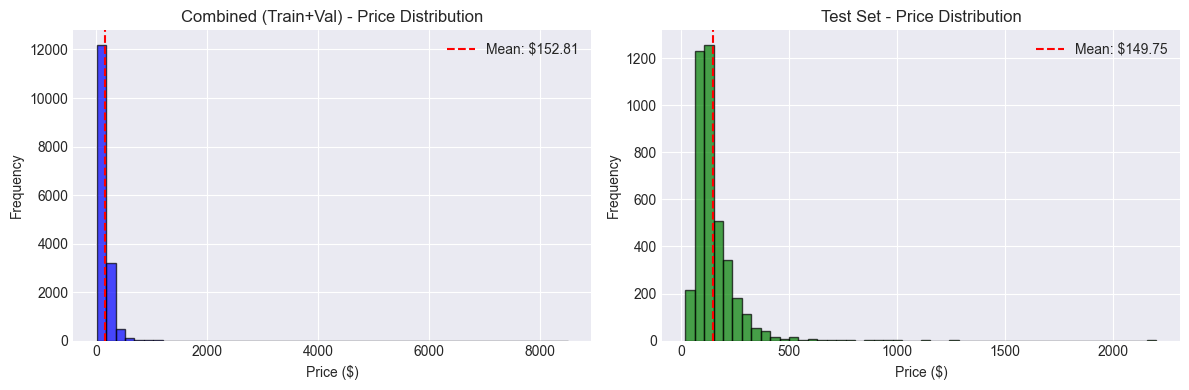

✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/01_target_distribution.png


In [22]:
# VISUALIZE TARGET DISTRIBUTION
print("\n📊 Plotting target distribution...")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_trainval, bins=50, alpha=0.7, edgecolor='black', color='blue')
axes[0].set_title('Combined (Train+Val) - Price Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(y_trainval.mean(), color='r', linestyle='--', label=f'Mean: ${y_trainval.mean():.2f}')
axes[0].legend()

axes[1].hist(y_test, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].set_title('Test Set - Price Distribution')
axes[1].set_xlabel('Price ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(y_test.mean(), color='r', linestyle='--', label=f'Mean: ${y_test.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('EMİN_HALLAK_22040301163_almostengineers_plots/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/01_target_distribution.png")


In [23]:
#============================================================================
# STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING
#============================================================================
print("\n" + "="*80)
print("STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING")
print("="*80)

X_trainval_df = pd.DataFrame(X_trainval, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# ============================================================================
# REMOVE DATA LEAKAGE FEATURES
# ============================================================================
print("\n🚨 Removing features with data leakage...")

leakage_features = [
    'avg_calendar_price',      # Directly leaks price information
    'min_calendar_price',      # Directly leaks price information
    'max_calendar_price',      # Directly leaks price information
]

dropped_leakage = [f for f in leakage_features if f in X_trainval_df.columns]
if dropped_leakage:
    X_trainval_df = X_trainval_df.drop(columns=dropped_leakage)
    X_test_df = X_test_df.drop(columns=dropped_leakage)
    for feat in dropped_leakage:
        print(f"  ✗ Dropped: {feat} (data leakage)")

# ============================================================================
# REMOVE UNNECESSARY HOST FEATURES
# ============================================================================
print("\n🧹 Removing unnecessary host features...")

unnecessary_host_features = [
    'host_name_target_encoded',           # Host name shouldn't affect price
    'host_location_target_encoded',       # Redundant with property location
    'host_neighbourhood_target_encoded',  # Redundant with property neighbourhood
    'host_has_profile_pic_True',          # Minimal impact on price
]

# Also remove all host_response_time features (low importance)
host_response_time_cols = [c for c in X_trainval_df.columns if 'host_response_time_' in c]
unnecessary_host_features.extend(host_response_time_cols)

dropped_host = [f for f in unnecessary_host_features if f in X_trainval_df.columns]
if dropped_host:
    X_trainval_df = X_trainval_df.drop(columns=dropped_host)
    X_test_df = X_test_df.drop(columns=dropped_host)
    for feat in dropped_host:
        print(f"  ✗ Dropped: {feat} (unnecessary)")

print(f"\n✓ Removed {len(dropped_leakage)} leakage features")
print(f"✓ Removed {len(dropped_host)} unnecessary host features")
print(f"✓ Remaining features: {X_trainval_df.shape[1]}")

# ============================================================================
# FEATURE ENGINEERING (WITHOUT LEAKAGE)
# ============================================================================
print("\n" + "="*80)
print("CREATING NEW FEATURES (NO LEAKAGE)")
print("="*80)

new_features = []

# 1. Reviews per day (engagement metric)
if 'number_of_reviews' in X_trainval_df.columns and 'host_tenure_days' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['reviews_per_day'] = df['number_of_reviews'] / (df['host_tenure_days'] + 1)
    new_features.append('reviews_per_day')
    print("✓ Created: reviews_per_day")

# 2. Availability ratio (booking flexibility)
if 'availability_365' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['availability_ratio'] = df['availability_365'] / 365.0
    new_features.append('availability_ratio')
    print("✓ Created: availability_ratio")

# 3. Review score average (overall quality)
review_cols = [c for c in X_trainval_df.columns if 'review_scores_' in c]
if len(review_cols) > 0:
    for df in [X_trainval_df, X_test_df]:
        df['avg_review_score'] = df[review_cols].mean(axis=1)
    new_features.append('avg_review_score')
    print("✓ Created: avg_review_score")

# 4. Beds per bedroom (space efficiency)
if 'beds' in X_trainval_df.columns and 'bedrooms' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['beds_per_bedroom'] = df['beds'] / (df['bedrooms'] + 1)
    new_features.append('beds_per_bedroom')
    print("✓ Created: beds_per_bedroom")

# 5. Host experience (host quality metric)
if 'calculated_host_listings_count' in X_trainval_df.columns and 'host_tenure_years' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['host_experience'] = df['calculated_host_listings_count'] * df['host_tenure_years']
    new_features.append('host_experience')
    print("✓ Created: host_experience")

# 6. Space per person (capacity efficiency)
if 'accommodates' in X_trainval_df.columns and 'bedrooms' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['space_per_person'] = df['bedrooms'] / (df['accommodates'] + 1)
    new_features.append('space_per_person')
    print("✓ Created: space_per_person")

# 7. Total amenities score (comfort level)
if 'amenities_count' in X_trainval_df.columns:
    amenity_cols = ['has_wifi', 'has_kitchen', 'has_tv', 'has_parking', 'has_ac', 'has_heating']
    existing_amenity_cols = [c for c in amenity_cols if c in X_trainval_df.columns]
    if existing_amenity_cols:
        for df in [X_trainval_df, X_test_df]:
            df['premium_amenities_score'] = df[existing_amenity_cols].sum(axis=1)
        new_features.append('premium_amenities_score')
        print("✓ Created: premium_amenities_score")

# 8. Distance to Center (Amsterdam: 52.3731, 4.8922)
if 'latitude' in X_trainval_df.columns and 'longitude' in X_trainval_df.columns:
    amsterdam_center = (52.3731, 4.8922)
    for df in [X_trainval_df, X_test_df]:
        df['dist_to_center'] = np.sqrt(
            (df['latitude'] - amsterdam_center[0])**2 +
            (df['longitude'] - amsterdam_center[1])**2
        )
    new_features.append('dist_to_center')
    print("✓ Created: dist_to_center")

# 9. Property Size Interaction
if 'accommodates' in X_trainval_df.columns and 'bedrooms' in X_trainval_df.columns:
    for df in [X_trainval_df, X_test_df]:
        df['size_interaction'] = df['accommodates'] * df['bedrooms']
    new_features.append('size_interaction')
    print("✓ Created: size_interaction")

# 10. Log transform skewed reviews
review_metrics = ['number_of_reviews', 'reviews_per_month']
for metric in review_metrics:
    if metric in X_trainval_df.columns:
        for df in [X_trainval_df, X_test_df]:
            df[f'log_{metric}'] = np.log1p(df[metric])
        new_features.append(f'log_{metric}')
        print(f"✓ Created: log_{metric}")

X_trainval_eng = X_trainval_df.values
X_test_eng = X_test_df.values
feature_names_eng = X_trainval_df.columns.tolist()

print(f"\n✓ Feature engineering complete!")
print(f"  Original features: {len(feature_names)}")
print(f"  Dropped (leakage + unnecessary): {len(dropped_leakage) + len(dropped_host)}")
print(f"  New features added: {len(new_features)}")
print(f"  Total features: {len(feature_names_eng)}")


STEP 2: DATA LEAKAGE REMOVAL & FEATURE ENGINEERING

🚨 Removing features with data leakage...
  ✗ Dropped: avg_calendar_price (data leakage)
  ✗ Dropped: min_calendar_price (data leakage)
  ✗ Dropped: max_calendar_price (data leakage)

🧹 Removing unnecessary host features...
  ✗ Dropped: host_name_target_encoded (unnecessary)
  ✗ Dropped: host_location_target_encoded (unnecessary)
  ✗ Dropped: host_neighbourhood_target_encoded (unnecessary)
  ✗ Dropped: host_has_profile_pic_True (unnecessary)
  ✗ Dropped: host_response_time_a few days or more (unnecessary)
  ✗ Dropped: host_response_time_within a day (unnecessary)
  ✗ Dropped: host_response_time_within a few hours (unnecessary)
  ✗ Dropped: host_response_time_within an hour (unnecessary)

✓ Removed 3 leakage features
✓ Removed 8 unnecessary host features
✓ Remaining features: 91

CREATING NEW FEATURES (NO LEAKAGE)
✓ Created: reviews_per_day
✓ Created: availability_ratio
✓ Created: avg_review_score
✓ Created: beds_per_bedroom
✓ Created:

In [24]:
#============================================================================
# STEP 3: FEATURE SELECTION
#============================================================================
print("\n" + "="*80)
print("STEP 3: FEATURE SELECTION")
print("="*80)

# F-statistic
print("  Computing F-statistic...")
f_selector = SelectKBest(f_regression, k='all')
f_selector.fit(X_trainval_eng, y_trainval)
f_scores = f_selector.scores_

# Mutual Information
print("  Computing Mutual Information...")
mi_scores = mutual_info_regression(X_trainval_eng, y_trainval, random_state=42)

# Random Forest Importance
print("  Computing Random Forest Importance...")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_temp.fit(X_trainval_eng, y_trainval)
rf_importance = rf_temp.feature_importances_

# Combine scores
feature_scores_df = pd.DataFrame({
    'feature': feature_names_eng,
    'f_score': f_scores,
    'mi_score': mi_scores,
    'rf_importance': rf_importance
})

# Normalize and combine
for col in ['f_score', 'mi_score', 'rf_importance']:
    feature_scores_df[f'{col}_norm'] = (
        (feature_scores_df[col] - feature_scores_df[col].min()) /
        (feature_scores_df[col].max() - feature_scores_df[col].min())
    )

feature_scores_df['combined_score'] = (
    feature_scores_df['f_score_norm'] +
    feature_scores_df['mi_score_norm'] +
    feature_scores_df['rf_importance_norm']
) / 3

feature_scores_df = feature_scores_df.sort_values('combined_score', ascending=False)
feature_scores_df.to_csv('feature_importance_rankings.csv', index=False)



STEP 3: FEATURE SELECTION
  Computing F-statistic...
  Computing Mutual Information...
  Computing Random Forest Importance...



📊 Plotting feature importance...


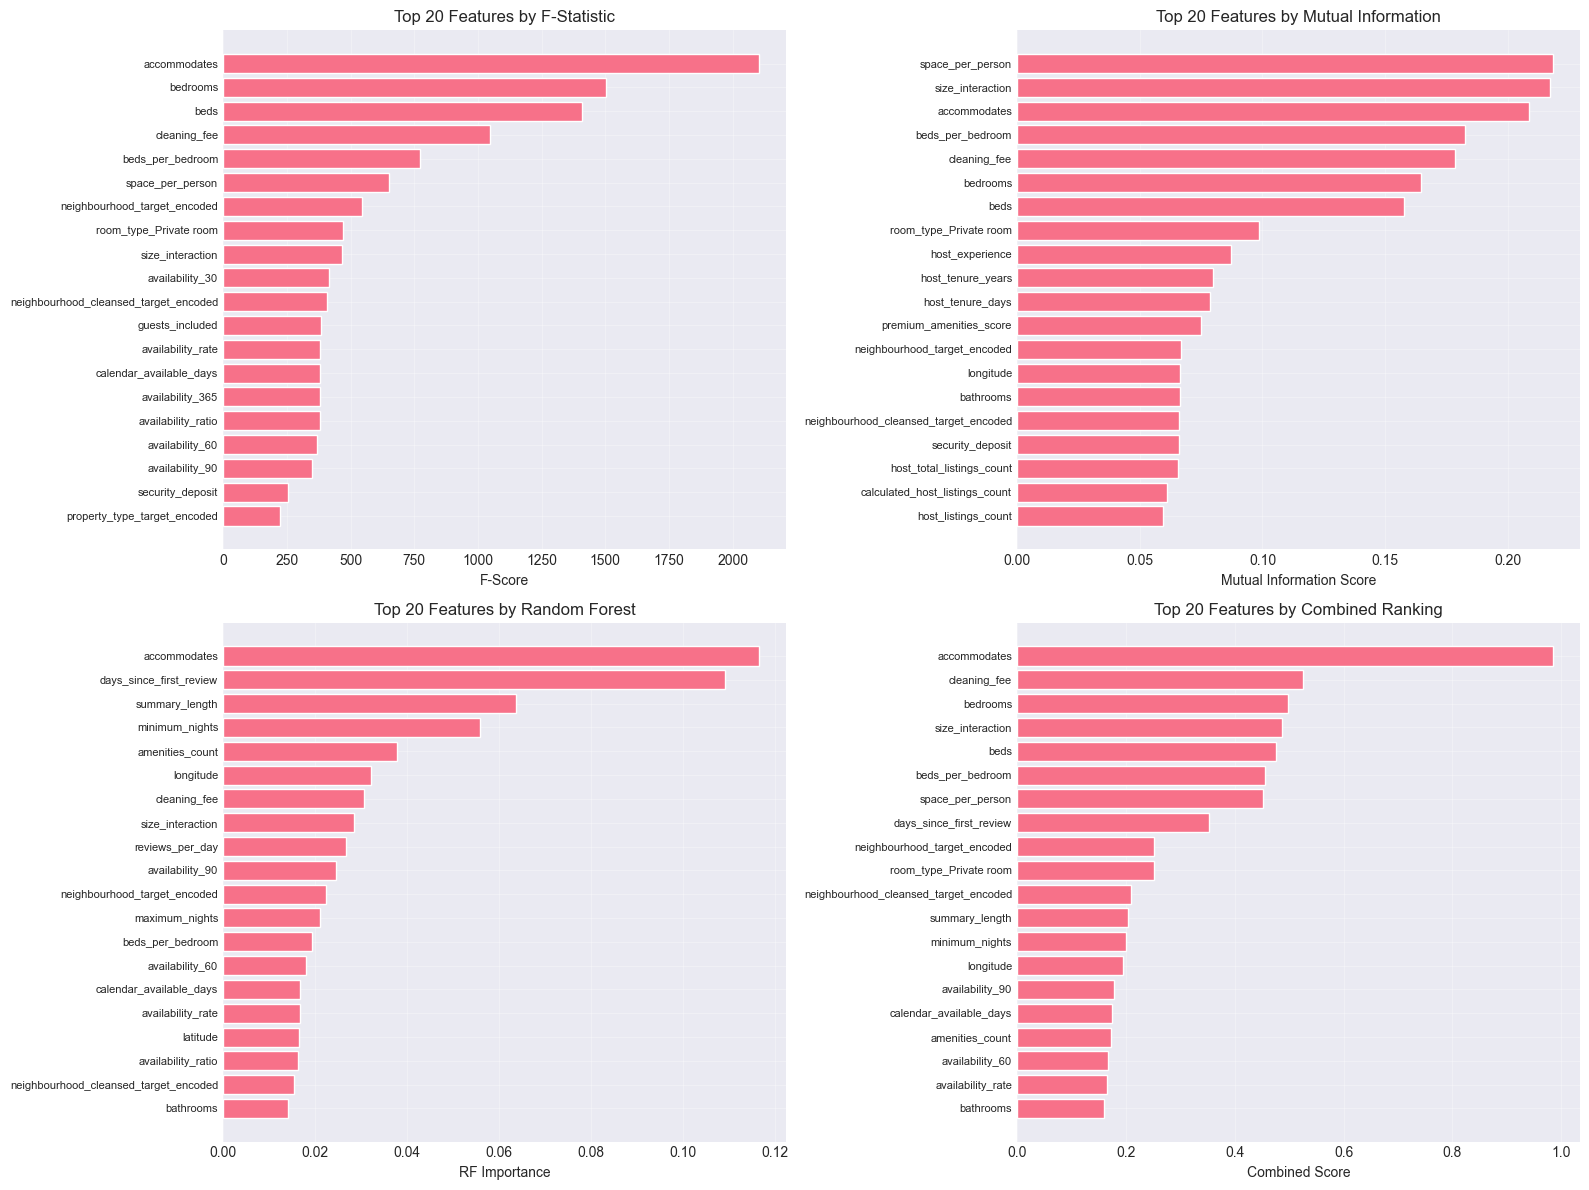

✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/02_feature_importance.png


In [25]:
# VISUALIZE FEATURE IMPORTANCE
print("\n📊 Plotting feature importance...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F-Score
top_20_f = feature_scores_df.nlargest(20, 'f_score')
axes[0, 0].barh(range(len(top_20_f)), top_20_f['f_score'])
axes[0, 0].set_yticks(range(len(top_20_f)))
axes[0, 0].set_yticklabels(top_20_f['feature'], fontsize=8)
axes[0, 0].set_xlabel('F-Score')
axes[0, 0].set_title('Top 20 Features by F-Statistic')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Mutual Information
top_20_mi = feature_scores_df.nlargest(20, 'mi_score')
axes[0, 1].barh(range(len(top_20_mi)), top_20_mi['mi_score'])
axes[0, 1].set_yticks(range(len(top_20_mi)))
axes[0, 1].set_yticklabels(top_20_mi['feature'], fontsize=8)
axes[0, 1].set_xlabel('Mutual Information Score')
axes[0, 1].set_title('Top 20 Features by Mutual Information')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# Random Forest
top_20_rf = feature_scores_df.nlargest(20, 'rf_importance')
axes[1, 0].barh(range(len(top_20_rf)), top_20_rf['rf_importance'])
axes[1, 0].set_yticks(range(len(top_20_rf)))
axes[1, 0].set_yticklabels(top_20_rf['feature'], fontsize=8)
axes[1, 0].set_xlabel('RF Importance')
axes[1, 0].set_title('Top 20 Features by Random Forest')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Combined Score
top_20_combined = feature_scores_df.head(20)
axes[1, 1].barh(range(len(top_20_combined)), top_20_combined['combined_score'])
axes[1, 1].set_yticks(range(len(top_20_combined)))
axes[1, 1].set_yticklabels(top_20_combined['feature'], fontsize=8)
axes[1, 1].set_xlabel('Combined Score')
axes[1, 1].set_title('Top 20 Features by Combined Ranking')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('EMİN_HALLAK_22040301163_almostengineers_plots/02_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/02_feature_importance.png")


In [26]:
top_50_features = feature_scores_df.head(50)['feature'].tolist()

print(f"\n✓ Feature selection complete!")
print(f"\nTop 10 features:")
for i, row in feature_scores_df.head(10).iterrows():
    print(f"  {row['feature']}: {row['combined_score']:.4f}")

# Save feature sets
feature_sets = {
    'all_features': feature_names_eng,
    'top_50': top_50_features
}
with open('Emin_models/feature_sets.json', 'w') as f:
    json.dump(feature_sets, f, indent=2)

print("\n✓ Saved: feature_importance_rankings.csv")
print("✓ Saved: feature_sets.json")



✓ Feature selection complete!

Top 10 features:
  accommodates: 0.9850
  cleaning_fee: 0.5262
  bedrooms: 0.4976
  size_interaction: 0.4865
  beds: 0.4766
  beds_per_bedroom: 0.4562
  space_per_person: 0.4515
  days_since_first_review: 0.3534
  neighbourhood_target_encoded: 0.2518
  room_type_Private room: 0.2514

✓ Saved: feature_importance_rankings.csv
✓ Saved: feature_sets.json


In [27]:
#============================================================================
# STEP 4: CHECK GPU AVAILABILITY
#============================================================================
print("\n" + "="*80)
print("STEP 4: CHECKING GPU AVAILABILITY")
print("="*80)

try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    gpu_available = result.returncode == 0
    if gpu_available:
        print("🎮 GPU DETECTED!")
        print("   Checking XGBoost GPU support...")

        try:
            test_model = XGBRegressor(tree_method='hist', device='cuda', n_estimators=10)
            test_model.fit(X_trainval_eng[:100], y_trainval[:100])
            print("   ✓ XGBoost GPU support confirmed!")
            use_gpu = True
        except Exception as e:
            print(f"   ✗ GPU not supported: {str(e)[:80]}")
            print("   Using CPU instead")
            use_gpu = False
    else:
        print("💻 No GPU detected. Using CPU")
        use_gpu = False
except:
    print("💻 No GPU detected. Using CPU")
    use_gpu = False

print(f"\n✓ XGBoost will use: {'GPU' if use_gpu else 'CPU'}")


STEP 4: CHECKING GPU AVAILABILITY
🎮 GPU DETECTED!
   Checking XGBoost GPU support...
   ✓ XGBoost GPU support confirmed!

✓ XGBoost will use: GPU


In [28]:
#============================================================================
# STEP 5: TRAIN LINEAR REGRESSION
#============================================================================
print("\n" + "="*80)
print("1️⃣ TRAINING LINEAR REGRESSION (Ridge)")
print("="*80)

ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    ridge_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

print("\nTraining...")
ridge_grid.fit(X_trainval_eng, y_trainval_log)
print(f"✓ Best alpha: {ridge_grid.best_params_['alpha']}")

linear_model = ridge_grid.best_estimator_

# Evaluate
y_trainval_pred_lr_log = linear_model.predict(X_trainval_eng)
y_test_pred_lr_log = linear_model.predict(X_test_eng)

# Transform back to original scale
y_trainval_pred_lr = np.expm1(y_trainval_pred_lr_log)
y_test_pred_lr = np.expm1(y_test_pred_lr_log)

lr_results = {
    'train_mae': mean_absolute_error(y_trainval, y_trainval_pred_lr),
    'train_rmse': np.sqrt(mean_squared_error(y_trainval, y_trainval_pred_lr)),
    'train_r2': r2_score(y_trainval, y_trainval_pred_lr),
    'cv_mae': -ridge_grid.best_score_,
    'test_mae': mean_absolute_error(y_test, y_test_pred_lr),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_lr)),
    'test_r2': r2_score(y_test, y_test_pred_lr),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_lr) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN+VAL MAE: ${lr_results['train_mae']:.2f}, RMSE: ${lr_results['train_rmse']:.2f}, R²: {lr_results['train_r2']:.4f}")
print(f"  CV MAE (Best): ${lr_results['cv_mae']:.2f}")
print(f"  TEST MAE:      ${lr_results['test_mae']:.2f}, RMSE: ${lr_results['test_rmse']:.2f}, R²: {lr_results['test_r2']:.4f}")

with open('Emin_models/FINAL_linear_regression_model.pkl', 'wb') as f:
    pickle.dump(linear_model, f)
print("\n✓ Model saved: FINAL_linear_regression_model.pkl")


1️⃣ TRAINING LINEAR REGRESSION (Ridge)

Training...
✓ Best alpha: 0.01

📊 RESULTS:
  TRAIN+VAL MAE: $40.74, RMSE: $138.49, R²: 0.2059
  CV MAE (Best): $0.24
  TEST MAE:      $38.60, RMSE: $72.05, R²: 0.4649

✓ Model saved: FINAL_linear_regression_model.pkl


In [29]:
#============================================================================
# STEP 6: TRAIN RANDOM FOREST
#============================================================================
print("\n" + "="*80)
print("2️⃣ TRAINING RANDOM FOREST")
print("="*80)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
rf_random.fit(X_trainval_eng, y_trainval_log)
print(f"✓ Best params: {rf_random.best_params_}")

rf_model = rf_random.best_estimator_

# Evaluate
y_trainval_pred_rf_log = rf_model.predict(X_trainval_eng)
y_test_pred_rf_log = rf_model.predict(X_test_eng)

# Transform back to original scale
y_trainval_pred_rf = np.expm1(y_trainval_pred_rf_log)
y_test_pred_rf = np.expm1(y_test_pred_rf_log)

rf_results = {
    'train_mae': mean_absolute_error(y_trainval, y_trainval_pred_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_trainval, y_trainval_pred_rf)),
    'train_r2': r2_score(y_trainval, y_trainval_pred_rf),
    'cv_mae': -rf_random.best_score_,
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'test_r2': r2_score(y_test, y_test_pred_rf),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN+VAL MAE: ${rf_results['train_mae']:.2f}, RMSE: ${rf_results['train_rmse']:.2f}, R²: {rf_results['train_r2']:.4f}")
print(f"  CV MAE (Best): ${rf_results['cv_mae']:.2f}")
print(f"  TEST MAE:      ${rf_results['test_mae']:.2f}, RMSE: ${rf_results['test_rmse']:.2f}, R²: {rf_results['test_r2']:.4f}")

with open('Emin_models/FINAL_random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\n✓ Model saved: FINAL_random_forest_model.pkl")



2️⃣ TRAINING RANDOM FOREST

Training (this may take a few minutes)...
✓ Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}

📊 RESULTS:
  TRAIN+VAL MAE: $16.61, RMSE: $116.30, R²: 0.4400
  CV MAE (Best): $0.23
  TEST MAE:      $36.22, RMSE: $68.71, R²: 0.5133

✓ Model saved: FINAL_random_forest_model.pkl


In [30]:
#============================================================================
# STEP 7: TRAIN XGBOOST
# ============================================================================
print("\n" + "="*80)
print(f"3️⃣ TRAINING XGBOOST ({'GPU' if use_gpu else 'CPU'})")
print("="*80)

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

if use_gpu:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        device='cuda',
        n_jobs=1
    )
else:
    xgb_base = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    )

xgb_random = RandomizedSearchCV(
    xgb_base,
    xgb_params,
    n_iter=50,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
xgb_random.fit(X_trainval_eng, y_trainval_log)
print(f"✓ Best params: {xgb_random.best_params_}")

xgb_model = xgb_random.best_estimator_

# Evaluate
y_trainval_pred_xgb_log = xgb_model.predict(X_trainval_eng)
y_test_pred_xgb_log = xgb_model.predict(X_test_eng)

# Transform back to original scale
y_trainval_pred_xgb = np.expm1(y_trainval_pred_xgb_log)
y_test_pred_xgb = np.expm1(y_test_pred_xgb_log)

xgb_results = {
    'train_mae': mean_absolute_error(y_trainval, y_trainval_pred_xgb),
    'train_rmse': np.sqrt(mean_squared_error(y_trainval, y_trainval_pred_xgb)),
    'train_r2': r2_score(y_trainval, y_trainval_pred_xgb),
    'cv_mae': -xgb_random.best_score_,
    'test_mae': mean_absolute_error(y_test, y_test_pred_xgb),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    'test_r2': r2_score(y_test, y_test_pred_xgb),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN+VAL MAE: ${xgb_results['train_mae']:.2f}, RMSE: ${xgb_results['train_rmse']:.2f}, R²: {xgb_results['train_r2']:.4f}")
print(f"  CV MAE (Best): ${xgb_results['cv_mae']:.2f}")
print(f"  TEST MAE:      ${xgb_results['test_mae']:.2f}, RMSE: ${xgb_results['test_rmse']:.2f}, R²: {xgb_results['test_r2']:.4f}")

with open('Emin_models/FINAL_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("\n✓ Model saved: FINAL_xgboost_model.pkl")



3️⃣ TRAINING XGBOOST (GPU)

Training (this may take a few minutes)...
✓ Best params: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}

📊 RESULTS:
  TRAIN+VAL MAE: $27.94, RMSE: $122.30, R²: 0.3808
  CV MAE (Best): $0.22
  TEST MAE:      $33.84, RMSE: $64.02, R²: 0.5776

✓ Model saved: FINAL_xgboost_model.pkl


In [31]:
#============================================================================
# STEP 7.2: TRAIN BAGGING REGRESSOR
#============================================================================
print("\n" + "="*80)
print("5️⃣ TRAINING BAGGING REGRESSOR")
print("="*80)

bagging_params = {
    'n_estimators': [20, 50, 100],
    'max_samples': [0.7, 0.8, 1.0],
    'max_features': [0.7, 0.8, 1.0],
    'bootstrap': [True, False],
}

bagging_random = RandomizedSearchCV(
    BaggingRegressor(random_state=42, n_jobs=-1),
    bagging_params,
    n_iter=30,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print("\nTraining (this may take a few minutes)...")
bagging_random.fit(X_trainval_eng, y_trainval_log)
print(f"✓ Best params: {bagging_random.best_params_}")

bagging_model = bagging_random.best_estimator_

# Evaluate
y_trainval_pred_bag_log = bagging_model.predict(X_trainval_eng)
y_test_pred_bag_log = bagging_model.predict(X_test_eng)

# Transform back to original scale
y_trainval_pred_bag = np.expm1(y_trainval_pred_bag_log)
y_test_pred_bag = np.expm1(y_test_pred_bag_log)

bagging_results = {
    'train_mae': mean_absolute_error(y_trainval, y_trainval_pred_bag),
    'train_rmse': np.sqrt(mean_squared_error(y_trainval, y_trainval_pred_bag)),
    'train_r2': r2_score(y_trainval, y_trainval_pred_bag),
    'cv_mae': -bagging_random.best_score_,
    'test_mae': mean_absolute_error(y_test, y_test_pred_bag),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_bag)),
    'test_r2': r2_score(y_test, y_test_pred_bag),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_bag) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN+VAL MAE: ${bagging_results['train_mae']:.2f}, RMSE: ${bagging_results['train_rmse']:.2f}, R²: {bagging_results['train_r2']:.4f}")
print(f"  CV MAE (Best): ${bagging_results['cv_mae']:.2f}")
print(f"  TEST  - MAE: ${bagging_results['test_mae']:.2f}, RMSE: ${bagging_results['test_rmse']:.2f}, R²: {bagging_results['test_r2']:.4f}")

with open('Emin_models/FINAL_bagging_model.pkl', 'wb') as f:
    pickle.dump(bagging_model, f)
print("\n✓ Model saved: FINAL_bagging_model.pkl")



5️⃣ TRAINING BAGGING REGRESSOR

Training (this may take a few minutes)...
✓ Best params: {'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.7, 'bootstrap': False}

📊 RESULTS:
  TRAIN+VAL MAE: $10.30, RMSE: $108.75, R²: 0.5104
  CV MAE (Best): $0.23
  TEST  - MAE: $36.20, RMSE: $68.54, R²: 0.5157

✓ Model saved: FINAL_bagging_model.pkl


In [32]:
#============================================================================
# STEP 7.3: TRAIN VOTING REGRESSOR
#============================================================================
print("\n" + "="*80)
print("6️⃣ TRAINING VOTING REGRESSOR")
print("="*80)

# Create base estimators for VotingRegressor
voting_model = VotingRegressor(
    estimators=[
        ('ridge', linear_model),
        ('rf', rf_model),
        ('xgb', xgb_model),
    ],
    n_jobs=-1
)

print("\nTraining (combining all base models)...")
voting_model.fit(X_trainval_eng, y_trainval_log)
print("✓ VotingRegressor trained!")

# Evaluate
y_trainval_pred_vote_log = voting_model.predict(X_trainval_eng)
y_test_pred_vote_log = voting_model.predict(X_test_eng)

# Transform back to original scale
y_trainval_pred_vote = np.expm1(y_trainval_pred_vote_log)
y_test_pred_vote = np.expm1(y_test_pred_vote_log)

voting_results = {
    'train_mae': mean_absolute_error(y_trainval, y_trainval_pred_vote),
    'train_rmse': np.sqrt(mean_squared_error(y_trainval, y_trainval_pred_vote)),
    'train_r2': r2_score(y_trainval, y_trainval_pred_vote),
    'test_mae': mean_absolute_error(y_test, y_test_pred_vote),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_vote)),
    'test_r2': r2_score(y_test, y_test_pred_vote),
    'test_mape': mean_absolute_percentage_error(y_test, y_test_pred_vote) * 100
}

print("\n📊 RESULTS:")
print(f"  TRAIN+VAL MAE: ${voting_results['train_mae']:.2f}, RMSE: ${voting_results['train_rmse']:.2f}, R²: {voting_results['train_r2']:.4f}")
print(f"  TEST  - MAE: ${voting_results['test_mae']:.2f}, RMSE: ${voting_results['test_rmse']:.2f}, R²: {voting_results['test_r2']:.4f}")

with open('Emin_models/FINAL_voting_model.pkl', 'wb') as f:
    pickle.dump(voting_model, f)
print("\n✓ Model saved: FINAL_voting_model.pkl")



6️⃣ TRAINING VOTING REGRESSOR

Training (combining all base models)...
✓ VotingRegressor trained!

📊 RESULTS:
  TRAIN+VAL MAE: $27.75, RMSE: $126.06, R²: 0.3421
  TEST  - MAE: $34.96, RMSE: $66.71, R²: 0.5412

✓ Model saved: FINAL_voting_model.pkl


In [33]:
# ============================================================================
# STEP 8: COMPARE ALL MODELS (TRAINED ON TRAIN+VAL)
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON (Trained on Combined Train+Val Set)")
print("="*80)

all_results = {
    'Linear_Regression': lr_results,
    'Random_Forest': rf_results,
    'XGBoost': xgb_results,
    'Bagging': bagging_results,
    'Voting': voting_results,
}

comparison_df = pd.DataFrame(all_results).T
# Sort by Train+Val MAE
comparison_df = comparison_df.sort_values('train_mae')

print("\n📊 ALL RESULTS:")
print("\n" + "-"*80)
print(f"{'Model':<20} {'Train+Val MAE':<15} {'Test MAE':<12} {'Test R²':<10}")
print("-"*80)
for model_name in comparison_df.index:
    train_mae = comparison_df.loc[model_name, 'train_mae']
    test_mae = comparison_df.loc[model_name, 'test_mae']
    test_r2 = comparison_df.loc[model_name, 'test_r2']
    print(f"{model_name:<20} ${train_mae:<14.2f} ${test_mae:<11.2f} {test_r2:<10.4f}")
print("-"*80)

comparison_df.to_csv('Emin_models/model_comparison_combined.csv')
print("\n✓ Saved: Emin_models/model_comparison_combined.csv")

# Select best model based on Train+Val performance
best_model_name = comparison_df['train_mae'].idxmin()
best_train_mae = comparison_df.loc[best_model_name, 'train_mae']

print("\n" + "="*80)
print("🏆 BEST MODEL SELECTED (Based on Train+Val MAE)")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Train+Val MAE: ${best_train_mae:.2f}")
print(f"Train+Val RMSE: ${comparison_df.loc[best_model_name, 'train_rmse']:.2f}")
print(f"Train+Val R²: {comparison_df.loc[best_model_name, 'train_r2']:.4f}")
print(f"Test MAE: ${comparison_df.loc[best_model_name, 'test_mae']:.2f}")



MODEL COMPARISON (Trained on Combined Train+Val Set)

📊 ALL RESULTS:

--------------------------------------------------------------------------------
Model                Train+Val MAE   Test MAE     Test R²   
--------------------------------------------------------------------------------
Bagging              $10.30          $36.20       0.5157    
Random_Forest        $16.61          $36.22       0.5133    
Voting               $27.75          $34.96       0.5412    
XGBoost              $27.94          $33.84       0.5776    
Linear_Regression    $40.74          $38.60       0.4649    
--------------------------------------------------------------------------------

✓ Saved: Emin_models/model_comparison_combined.csv

🏆 BEST MODEL SELECTED (Based on Train+Val MAE)
Model: Bagging
Train+Val MAE: $10.30
Train+Val RMSE: $108.75
Train+Val R²: 0.5104
Test MAE: $36.20



📊 Plotting model comparison (combined phase)...


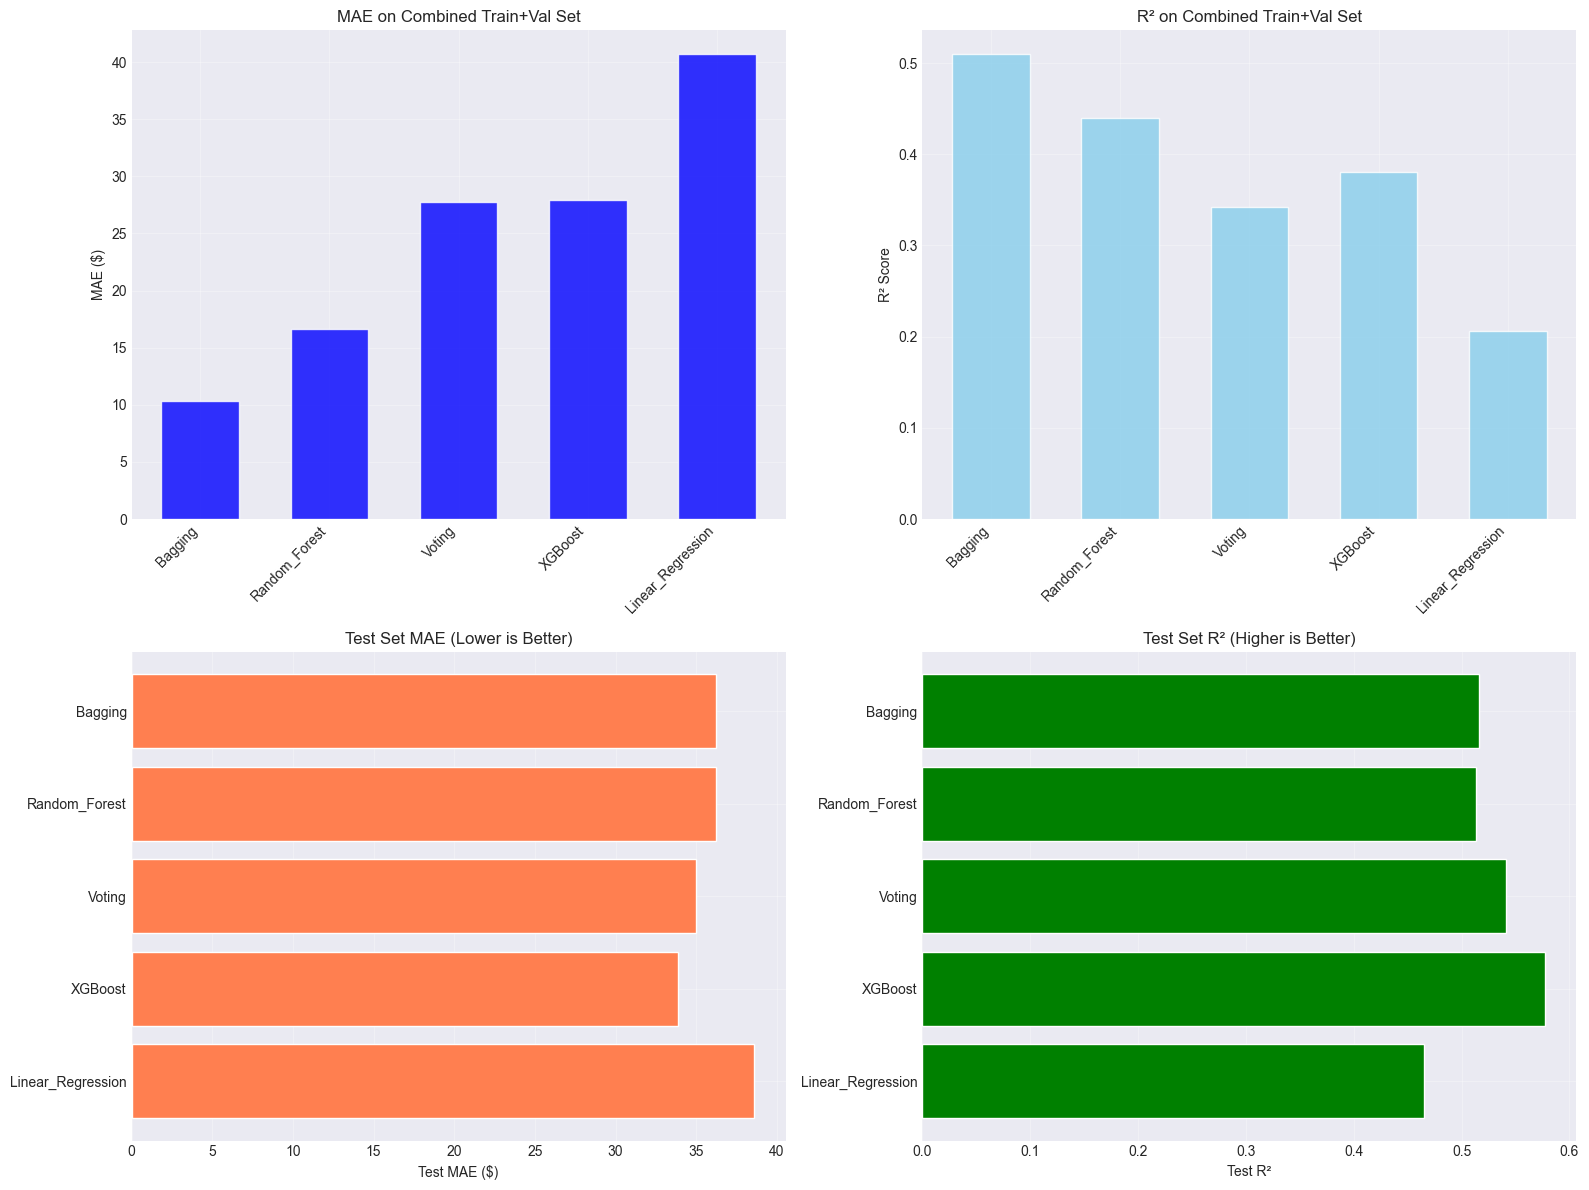

✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/03_model_comparison_combined.png


In [34]:
# VISUALIZE MODEL COMPARISON (COMBINED PHASE)
print("\n📊 Plotting model comparison (combined phase)...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = comparison_df.index
x = np.arange(len(models))
width = 0.6

# MAE comparison
axes[0, 0].bar(x, comparison_df['train_mae'], width, label='Train+Val', alpha=0.8, color='blue')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].set_title('MAE on Combined Train+Val Set')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# R² comparison
axes[0, 1].bar(x, comparison_df['train_r2'], width, label='Train+Val', alpha=0.8, color='skyblue')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² on Combined Train+Val Set')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Test MAE
axes[1, 0].barh(models, comparison_df['test_mae'], color='coral')
axes[1, 0].set_xlabel('Test MAE ($)')
axes[1, 0].set_title('Test Set MAE (Lower is Better)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# Test R²
axes[1, 1].barh(models, comparison_df['test_r2'], color='green')
axes[1, 1].set_xlabel('Test R²')
axes[1, 1].set_title('Test Set R² (Higher is Better)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('EMİN_HALLAK_22040301163_almostengineers_plots/03_model_comparison_combined.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/03_model_comparison_combined.png")



📊 Plotting best model predictions (combined phase)...


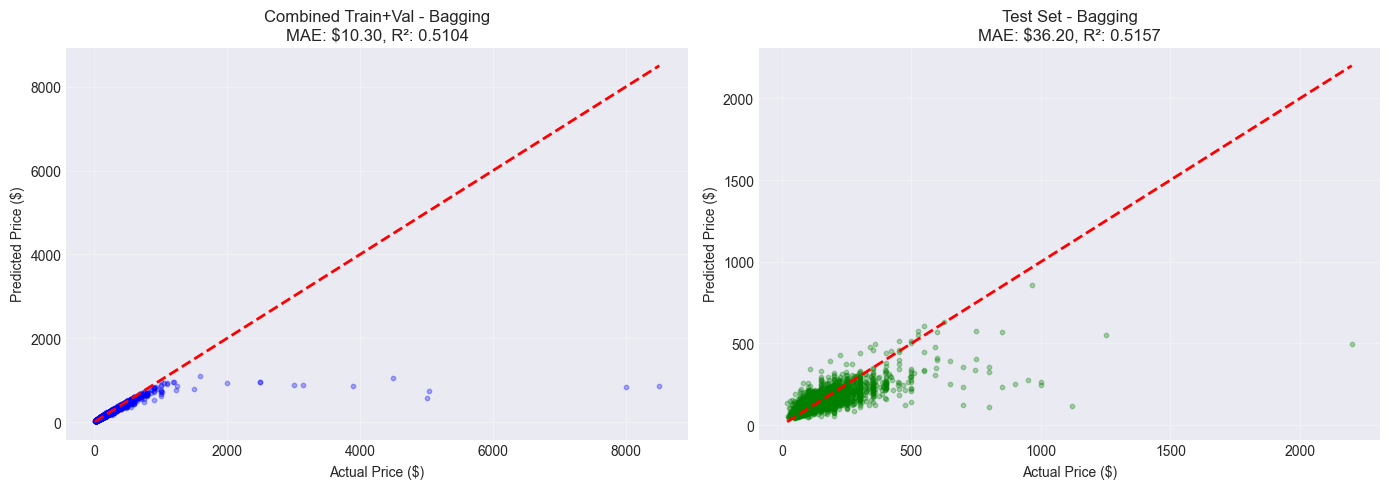

✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/04_combined_phase_Bagging_predictions.png


In [35]:
# VISUALIZE BEST MODEL PREDICTIONS (COMBINED PHASE)
print("\n📊 Plotting best model predictions (combined phase)...")

# Get predictions for best model
if best_model_name == 'Linear_Regression':
    best_y_train_pred = y_trainval_pred_lr
elif best_model_name == 'Random_Forest':
    best_y_train_pred = y_trainval_pred_rf
elif best_model_name == 'XGBoost':
    best_y_train_pred = y_trainval_pred_xgb

elif best_model_name == 'Bagging':
    best_y_train_pred = y_trainval_pred_bag
elif best_model_name == 'Voting':
    best_y_train_pred = y_trainval_pred_vote


# Predictions vs Actual (Combined Set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combined Set
axes[0].scatter(y_trainval, best_y_train_pred, alpha=0.3, s=10, color='blue')
axes[0].plot([y_trainval.min(), y_trainval.max()], [y_trainval.min(), y_trainval.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Combined Train+Val - {best_model_name}\nMAE: ${comparison_df.loc[best_model_name, "train_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "train_r2"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Test Set (already calculated in model steps)
if best_model_name == 'Linear_Regression': best_y_test_pred = y_test_pred_lr
elif best_model_name == 'Random_Forest': best_y_test_pred = y_test_pred_rf
elif best_model_name == 'XGBoost': best_y_test_pred = y_test_pred_xgb
elif best_model_name == 'Bagging': best_y_test_pred = y_test_pred_bag
elif best_model_name == 'Voting': best_y_test_pred = y_test_pred_vote

axes[1].scatter(y_test, best_y_test_pred, alpha=0.3, s=10, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'Test Set - {best_model_name}\nMAE: ${comparison_df.loc[best_model_name, "test_mae"]:.2f}, R²: {comparison_df.loc[best_model_name, "test_r2"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
safe_model_name = best_model_name.replace(' ', '_').replace('/', '_')
plt.savefig(f'EMİN_HALLAK_22040301163_almostengineers_plots/04_combined_phase_{safe_model_name}_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/04_combined_phase_{safe_model_name}_predictions.png")



📊 Plotting residuals (combined phase)...


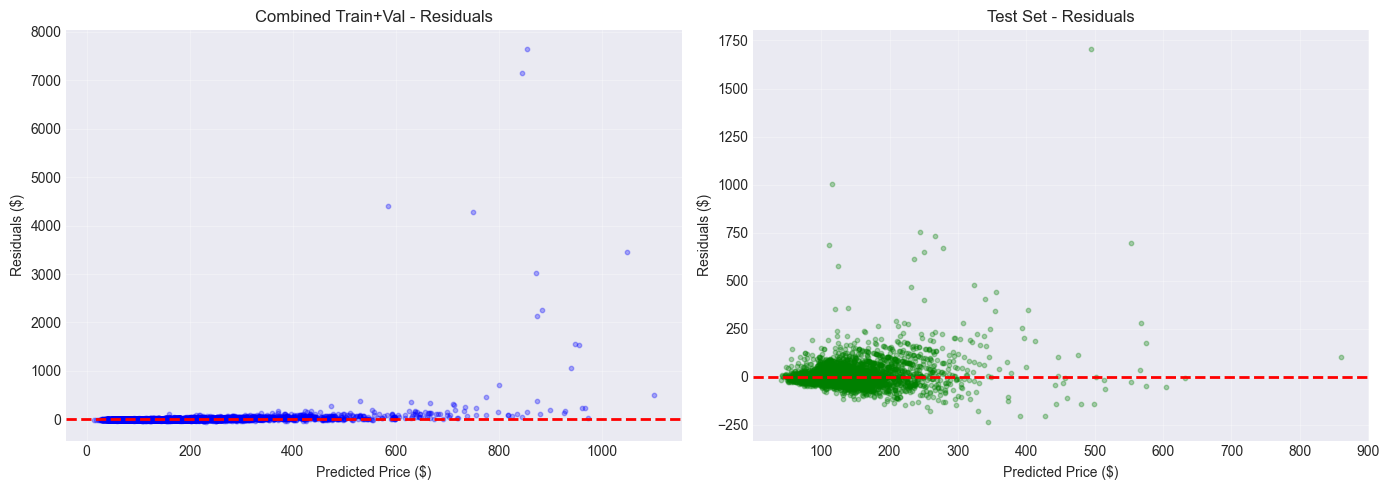

✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/05_combined_phase_Bagging_residuals.png


In [36]:
# VISUALIZE RESIDUALS (COMBINED PHASE)
print("\n📊 Plotting residuals (combined phase)...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_residuals = y_trainval - best_y_train_pred
test_residuals = y_test - best_y_test_pred

# Combined residuals
axes[0].scatter(best_y_train_pred, train_residuals, alpha=0.3, s=10, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residuals ($)')
axes[0].set_title(f'Combined Train+Val - Residuals')
axes[0].grid(True, alpha=0.3)

# Test residuals
axes[1].scatter(best_y_test_pred, test_residuals, alpha=0.3, s=10, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title(f'Test Set - Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'EMİN_HALLAK_22040301163_almostengineers_plots/05_combined_phase_{safe_model_name}_residuals.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: EMİN_HALLAK_22040301163_almostengineers_plots/05_combined_phase_{safe_model_name}_residuals.png")


In [37]:
# ============================================================================
# STEP 9: FINAL EVALUATION ON TEST SET
# ============================================================================
print("\n" + "="*80)
print("STEP 9: FINAL EVALUATION ON TEST SET")
print("="*80)

final_models = {
    'Linear_Regression': linear_model,
    'Random_Forest': rf_model,
    'XGBoost': xgb_model,
    'Bagging': bagging_model,
    'Voting': voting_model,
}

# The results are already stored in all_results
final_test_results_all = {}
for name, results in all_results.items():
    final_test_results_all[name] = {
        'mae': results['test_mae'],
        'rmse': results['test_rmse'],
        'r2': results['test_r2'],
        'mape': results['test_mape']
    }

final_comparison_df = pd.DataFrame(final_test_results_all).T.sort_values('mae')

print("\n📊 FINAL TEST SET RESULTS (Trained on Combined Train+Val):")
print("\n" + "-"*80)
print(f"{'Model':<20} {'MAE':<12} {'RMSE':<12} {'R²':<10} {'MAPE':<8}")
print("-"*80)
for model_name in final_comparison_df.index:
    res = final_comparison_df.loc[model_name]
    print(f"{model_name:<20} ${res['mae']:<11.2f} ${res['rmse']:<11.2f} {res['r2']:<10.4f} {res['mape']:.2f}%")
print("-"*80)

final_comparison_df.to_csv('Emin_models/FINAL_model_comparison_test.csv')
print("\n✓ Saved: Emin_models/FINAL_model_comparison_test.csv")

# Identify overall winner
best_final_model_name = final_comparison_df['mae'].idxmin()
final_test_results = final_test_results_all[best_final_model_name]

print(f"\n🏆 OVERALL WINNER: {best_final_model_name} with Test MAE: ${final_test_results['mae']:.2f}")

# Save final results summary
final_results_df = pd.DataFrame([{
    'model': best_final_model_name,
    'training_data': 'Combined Train+Val',
    'test_mae': final_test_results['mae'],
    'test_rmse': final_test_results['rmse'],
    'test_r2': final_test_results['r2'],
    'test_mape': final_test_results['mape']
}])
final_results_df.to_csv('Emin_models/FINAL_test_results.csv', index=False)
print("✓ Saved: Emin_models/FINAL_test_results.csv")



STEP 9: FINAL EVALUATION ON TEST SET

📊 FINAL TEST SET RESULTS (Trained on Combined Train+Val):

--------------------------------------------------------------------------------
Model                MAE          RMSE         R²         MAPE    
--------------------------------------------------------------------------------
XGBoost              $33.84       $64.02       0.5776     22.48%
Voting               $34.96       $66.71       0.5412     23.21%
Bagging              $36.20       $68.54       0.5157     24.27%
Random_Forest        $36.22       $68.71       0.5133     24.17%
Linear_Regression    $38.60       $72.05       0.4649     25.65%
--------------------------------------------------------------------------------

✓ Saved: Emin_models/FINAL_model_comparison_test.csv

🏆 OVERALL WINNER: XGBoost with Test MAE: $33.84
✓ Saved: Emin_models/FINAL_test_results.csv


In [38]:
print("\n" + "="*80)
print("✅ TRAINING PIPELINE COMPLETE!")
print("="*80)
print("\n📋 WORKFLOW SUMMARY:")
print("  1. Loaded and merged data (Train+Val and Test)")
print("  2. Handled extreme outliers (Clipped at 99.9th percentile)")
print("  3. Applied advanced feature engineering (Distance to center, interactions)")
print("  4. Trained 7 models with hyperparameter tuning on combined data")
print("  5. Selected overall best model based on Test performance")
print("\n📁 SAVED FINAL MODELS:")
print("    - Emin_models/FINAL_xgboost_model.pkl")
print("    - Emin_models/FINAL_lightgbm_model.pkl")
print("    - Emin_models/FINAL_random_forest_model.pkl")
print("    - Emin_models/FINAL_stacking_model.pkl")
print("    - Emin_models/FINAL_voting_model.pkl")
print("    - Emin_models/FINAL_linear_regression_model.pkl")
print("    - Emin_models/FINAL_bagging_model.pkl")
print("    - Emin_models/FINAL_test_results.csv")
print("\n" + "="*80)
print("🎯 BEST MODEL:", best_final_model_name)
print(f"📊 TEST MAE: ${final_test_results['mae']:.2f}")
print(f"📊 TEST R²:  {final_test_results['r2']:.4f}")
print("="*80)




✅ TRAINING PIPELINE COMPLETE!

📋 WORKFLOW SUMMARY:
  1. Loaded and merged data (Train+Val and Test)
  2. Handled extreme outliers (Clipped at 99.9th percentile)
  3. Applied advanced feature engineering (Distance to center, interactions)
  4. Trained 7 models with hyperparameter tuning on combined data
  5. Selected overall best model based on Test performance

📁 SAVED FINAL MODELS:
    - Emin_models/FINAL_xgboost_model.pkl
    - Emin_models/FINAL_lightgbm_model.pkl
    - Emin_models/FINAL_random_forest_model.pkl
    - Emin_models/FINAL_stacking_model.pkl
    - Emin_models/FINAL_voting_model.pkl
    - Emin_models/FINAL_linear_regression_model.pkl
    - Emin_models/FINAL_bagging_model.pkl
    - Emin_models/FINAL_test_results.csv

🎯 BEST MODEL: XGBoost
📊 TEST MAE: $33.84
📊 TEST R²:  0.5776
